In [ ]:
##GENERAL
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import Counter
import csv
import re
import os

##SPACY
import spacy
nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('en_core_web_md')
#nlp = spacy.load('en_core_web_lg')
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
from spacy.tokens import Span
from spacy.pipeline import SentenceSegmenter
from spacy import displacy

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

##SKLEARN
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


##Loading in the data

In [ ]:
data = pd.read_csv('/gdrive/My Drive/data/amazon_products.csv')
data = data.drop(columns=['Unnamed: 0'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58828 entries, 0 to 58827
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   review           58828 non-null  object
 1   clean_review     58828 non-null  object
 2   review_category  58828 non-null  object
 3   topic_category   58828 non-null  int64 
 4   topic_name       58828 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [ ]:
data['review_category'].value_counts()

Bad        33406
Good       16535
Average     8887
Name: review_category, dtype: int64

In [ ]:
data['topic_name'].unique()

array(['books', 'video-quality', 'refund-and-return', 'movies', 'music',
       'games'], dtype=object)

##Creating the Text to Categorical Columns

In [ ]:
data['topic_name']=data['topic_name'].astype('category')
data['topic_name'].cat.categories
data['topic_category_codes']=data['topic_name'].cat.codes.values
data = data.drop(columns=['review','review_category','topic_category','topic_name'])
data.head()

,clean_review,topic_category_codes
0,this self published book want know read paragr...,0
1,rather scratches insect droppings random pixel...,5
2,my experience got fm Amazon the dvd player rat...,5
3,ordered dvd received substitute received dvd o...,5
4,disappointed performance it underpowered const...,4


In [ ]:
sentences = data['clean_review'].values
labels = data['topic_category_codes'].values

##Declaring Variables

In [ ]:
# some configuration
MAX_SEQUENCE_LENGTH = 75
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 50
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 80
output_dir = '/gdrive/My Drive/amazon_review_full_csv'

##Creating Train and Test Dataset

In [ ]:
df_train, df_test, Ytrain, Ytest = train_test_split(sentences, labels, test_size=0.20)

##Tokenization and Padding

In [ ]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)


In [ ]:
idx2word = tokenizer.index_word
#word2idx = {k:v for v,k in idx2word.items()}
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))
print(word2idx['instead'])
print(idx2word[157])

Found 70326 unique tokens.
145
page


In [ ]:
seq_len = [len(sent) for sent in sequences_train]
max_seq_len = max(seq_len)
print(f'maximum sequencse length {max_seq_len}')
padded_data_train = tf.keras.preprocessing.sequence.pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', padded_data_train.shape)
padded_data_test = tf.keras.preprocessing.sequence.pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data test tensor:', padded_data_test.shape)

maximum sequencse length 155
Shape of data tensor: (47062, 75)
Shape of data test tensor: (11766, 75)


##Creating the Embedding Matrix using Glove() pretrained vectors

In [ ]:
# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('/gdrive/My Drive/data/glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  for line in f:
    values = line.split()
    word = values[0]
    value = np.asarray(values[1:] , dtype='float32')
    word2vec[word]=value
print(len(word2vec))

Loading word vectors...
400000


In [ ]:
# prepare embedding matrix
#print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word,i in word2idx.items():
  #print(word)
  #print(i)
  if i < MAX_VOCAB_SIZE:
    embedding_vector= word2vec.get(word)
    if embedding_vector is not None:
      embedding_matrix[i]=embedding_vector
print(embedding_matrix.shape)

(20000, 50)


In [ ]:
embedding_layer = Embedding(
    num_words,
    EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False
)

In [ ]:
type(df_train)

numpy.ndarray

##Model Architecture

In [ ]:
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
embeddings = embedding_layer(input_)
lstm_1 = LSTM(256, return_sequences=True, return_state=False, dropout=0.2)(embeddings)
lstm_2 = LSTM(256, return_sequences=True, return_state=False, dropout=0.2)
lstm_layer = lstm_2(lstm_1)
gmpl= GlobalMaxPool1D(name='gmpl')(lstm_layer)
dense = Dense(6)
output = dense(gmpl)
model = Model(input_, output)

In [ ]:
model.compile(
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(lr=0.0001),
  metrics=['accuracy']
)
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 50)            1000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 75, 256)           314368    
_________________________________________________________________
lstm_3 (LSTM)                (None, 75, 256)           525312    
_________________________________________________________________
gmpl (GlobalMaxPooling1D)    (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 1,841,222
Trainable params: 841,222
Non-trainable params: 1,000,000
___________________________________________

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

checkpoint = ModelCheckpoint("/content/drive/My Drive/models/amazon_lstm.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

# we put our call backs into a callback list
callbacks = [earlystop, checkpoint]

##Model Training

In [ ]:
r = model.fit(padded_data_train,
        Ytrain,
        batch_size=228,
  epochs=10,
  callbacks=callbacks,
  validation_data=(padded_data_test, Ytest)
)  

Epoch 1/10
207/207 [==============================] - ETA: 0s - loss: 0.8959 - accuracy: 0.6924
Epoch 00001: val_loss improved from inf to 0.54145, saving model to /content/drive/My Drive/models/amazon_lstm.h5
207/207 [==============================] - 23s 109ms/step - loss: 0.8959 - accuracy: 0.6924 - val_loss: 0.5415 - val_accuracy: 0.8238
Epoch 2/10
207/207 [==============================] - ETA: 0s - loss: 0.5033 - accuracy: 0.8390
Epoch 00002: val_loss improved from 0.54145 to 0.40800, saving model to /content/drive/My Drive/models/amazon_lstm.h5
207/207 [==============================] - 22s 105ms/step - loss: 0.5033 - accuracy: 0.8390 - val_loss: 0.4080 - val_accuracy: 0.8700
Epoch 3/10
207/207 [==============================] - ETA: 0s - loss: 0.4317 - accuracy: 0.8613
Epoch 00003: val_loss improved from 0.40800 to 0.38264, saving model to /content/drive/My Drive/models/amazon_lstm.h5
207/207 [==============================] - 22s 105ms/step - loss: 0.4317 - accuracy: 0.8613 - 

##Plotting

In [ ]:
x1=[x for x in range(len(r.history['loss']))]
x2=[x for x in range(len(r.history['loss']))]
x3=[x for x in range(len(r.history['loss']))]
x4=[x for x in range(len(r.history['loss']))]
y1=r.history['loss']
y2=r.history['val_loss']
y3=r.history['accuracy']
y4=r.history['val_accuracy']

In [ ]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
get_ipython().events.register('pre_run_cell', configure_plotly_browser_state)

##Training and Validation Loss

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
#fig.add_trace(go.Scatter(x=[x for x in range(len(r.history['loss']))], y=r.history['loss'] , mode='lines', name='VOLUME',line=dict(color='#00b8b8', width=2)))
fig.add_trace(go.Scatter(x=x1, y=y1, mode='lines+markers', name='train_loss', line=dict(color='#00b8b8', width=4)))
fig.add_trace(go.Scatter(x=x2, y=y2, mode='lines+markers', name='val_loss', line=dict(color='#e4bd0b', width=4)))
fig.update_layout(width=800,
        height=600,legend=dict(x=.70,y=0.85, traceorder='reversed', font_size=16), 
        yaxis=dict(
        title="Training and Validation Loss",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),)
fig.show()



##Training and Validation Accuracy

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
#fig.add_trace(go.Scatter(x=[x for x in range(len(r.history['loss']))], y=r.history['loss'] , mode='lines', name='VOLUME',line=dict(color='#00b8b8', width=2)))
fig.add_trace(go.Scatter(x=x3, y=y3, mode='lines+markers', name='train_accuracy', line=dict(color='#00b8b8', width=4)))
fig.add_trace(go.Scatter(x=x4, y=y4, mode='lines+markers', name='val_accuracy', line=dict(color='#e4bd0b', width=4)))
fig.update_layout(width=800,
        height=600,legend=dict(x=.70,y=0.85, traceorder='reversed', font_size=16), 
        yaxis=dict(
        title="Training and Validation Accuracy",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        )
    ),)
fig.show()

##Saving the Model

In [ ]:
model.save('/gdrive/My Drive/models/amazon_lstm_pre_padding.h5')

##Model Predictions

In [ ]:
y_hat = model.predict(padded_data_test)
y_hat = np.argmax(y_hat, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

##Model Performance

Confusion matrix, without normalization
[[3063    2   34   14   95   17]
 [  13  246    9    1   58    4]
 [  12    3  910    6   19   26]
 [  30    0    9 1479   59   16]
 [ 111   10   48   38 4363   26]
 [  13    5  110   14   35  868]]


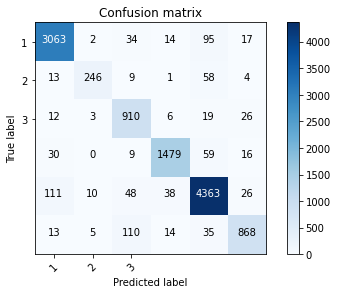

In [ ]:
cm = confusion_matrix(Ytest, y_hat)
plot_confusion_matrix(cm, [1, 2, 3])